In [ ]:
import os
import random
import shutil
import glob as gb
from tqdm import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D,Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

from keras import Model
from keras.layers import Input

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

2024-12-11 07:31:33.405471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 07:31:33.405627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 07:31:33.532238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def visualize_random_images(male_folder, female_folder, num_images=5):
    male_images = os.listdir(male_folder)
    female_images = os.listdir(female_folder)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i in range(num_images):
        male_image_path = os.path.join(male_folder, random.choice(male_images))
        female_image_path = os.path.join(female_folder, random.choice(female_images))

        male_img = plt.imread(male_image_path)
        female_img = plt.imread(female_image_path)

        axes[0, i].imshow(male_img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Male')

        axes[1, i].imshow(female_img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Female')

    plt.show()

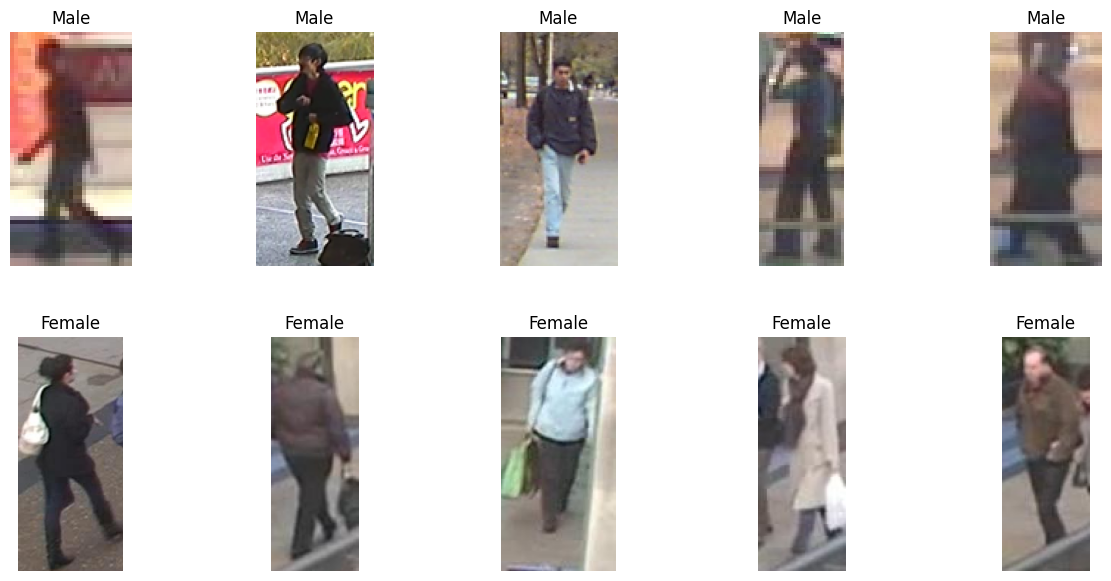

In [ ]:
male_folder = '/kaggle/input/cctv-gender-classifier-dataset/CCTV Gender Classifier Dataset/MALE'
female_folder = '/kaggle/input/cctv-gender-classifier-dataset/CCTV Gender Classifier Dataset/FEMALE'

visualize_random_images(male_folder, female_folder)

In [ ]:
num_male_images = len(os.listdir(male_folder))
num_female_images = len(os.listdir(female_folder))

print(f"Total number of male images: {num_male_images}")
print(f"Total number of female images: {num_female_images}")

Total number of male images: 9447
Total number of female images: 9676


In [ ]:
DataPath = '/kaggle/input/cctv-gender-classifier-dataset/CCTV Gender Classifier Dataset'

labels2int={"MALE":0,"FEMALE":1}
int2labels={0:"MALE",1:"FEMALE"}

Data = []
Classes = []

# Iterate through each folder in DataPath
for folder in os.listdir(DataPath):
    print(folder)

    # Construct the full path to the folder
    folder_path = os.path.join(DataPath, folder)

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    print(f"Data found {len(files)} in {folder}")

    # Iterate through each file in the folder
    for file in files:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file)

        # Load the image, resize it, and convert it to an array
        img = load_img(file_path, target_size=(200, 100))
        img_array = img_to_array(img)

        # Preprocess the image array
        img_array = preprocess_input(img_array)

        # Append the preprocessed image array to the Data list
        Data.append(img_array)

        # Append the label to the Classes list based on the folder name
        Classes.append(labels2int[folder])

FEMALE
Data found 9676 in FEMALE
MALE
Data found 9447 in MALE


In [ ]:
print("Length of Classes before binarization:", len(Classes))

Length of Classes before binarization: 19123


In [ ]:
lb = LabelBinarizer()
Classes = lb.fit_transform(Classes)
Classes = to_categorical(Classes)

In [ ]:
print("Shape of Classes after binarization and conversion:", Classes.shape)

Shape of Classes after binarization and conversion: (19123, 2)


In [ ]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
trainx,testx,trainy,testy = train_test_split(Data,Classes,test_size=0.20,stratify=Classes,
                                             random_state=42,shuffle=True)
print("Shape of training data (trainx):", trainx.shape)
print("Shape of testing data (testx):", testx.shape)
print("Shape of training labels (trainy):", trainy.shape)
print("Shape of testing labels (testy):", testy.shape)

Shape of training data (trainx): (15298, 200, 100, 3)
Shape of testing data (testx): (3825, 200, 100, 3)
Shape of training labels (trainy): (15298, 2)
Shape of testing labels (testy): (3825, 2)


In [ ]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
# Split data into training and testing sets (80% train, 20% test)
Data_train, Data_test, Classes_train, Classes_test = train_test_split(Data, Classes, test_size=0.2, random_state=42)

# Split training data into training and validation sets (80% train, 20% validation)
Data_train, Data_val, Classes_train, Classes_val = train_test_split(Data_train, Classes_train, test_size=0.2, random_state=42)

print("Shape of training data (Data_train):", Data_train.shape)
print("Shape of Validation data (Data_val):", Data_val.shape)
print("Shape of testing data (Data_test):", Data_test.shape)
print('=============================================================')
print("Shape of training labels (Classes_train):", Classes_train.shape)
print("Shape of Validation labels (Classes_test):", Classes_val.shape)
print("Shape of testing labels (Classes_test):", Classes_test.shape)

Shape of training data (Data_train): (12238, 200, 100, 3)
Shape of Validation data (Data_val): (3060, 200, 100, 3)
Shape of testing data (Data_test): (3825, 200, 100, 3)
Shape of training labels (Classes_train): (12238, 2)
Shape of Validation labels (Classes_test): (3060, 2)
Shape of testing labels (Classes_test): (3825, 2)


In [ ]:
def resnet50_modelarch():
    lr = 1e-5
    epochs = 10

    basemodel= ResNet50(include_top=False, input_shape=(200,100,3))
    headmodel= basemodel.output
    headmodel= AveragePooling2D(pool_size=(3,3))(headmodel)

    #headmodel = Dense(1024, activation="relu")(headmodel)
    #headmodel = Dropout(0.3)(headmodel)
    headmodel = Flatten(name="flatten")(headmodel)
    headmodel = Dense(512, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(256, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(128, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(64, activation="relu")(headmodel)
    #headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(2, activation='softmax')(headmodel)

    model=Model(inputs=basemodel.input, outputs=headmodel)

    for layer in basemodel.layers:
        layer.trainable=False

    opt=Adam(learning_rate=lr, decay=lr / epochs)
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
    callback = EarlyStopping(monitor='val_loss',patience=6)

    return model,callback,epochs

In [ ]:
model,callback,Epochs = resnet50_modelarch()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 50,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 50,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 50,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 52,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 25,857,986 (98.64 MB)

 Trainable params: 2,270,274 (8.66 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(Data_train,Classes_train,
                    batch_size=32,
                    validation_data=(Data_val,Classes_val),
                    epochs=30,callbacks=[callback])

Epoch 1/30
  5/383 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5155 - loss: 0.8691 

I0000 00:00:1733902409.163349      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1733902409.208910      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5370 - loss: 0.7901

W0000 00:00:1733902430.128633      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1733902435.466500      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.5371 - loss: 0.7900 - val_accuracy: 0.6614 - val_loss: 0.6355
Epoch 2/30
  5/383 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5872 - loss: 0.7076

W0000 00:00:1733902441.245324      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6064 - loss: 0.6863 - val_accuracy: 0.6925 - val_loss: 0.5985
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6590 - loss: 0.6356 - val_accuracy: 0.7078 - val_loss: 0.5736
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6934 - loss: 0.5972 - val_accuracy: 0.7235 - val_loss: 0.5477
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7110 - loss: 0.5746 - val_accuracy: 0.7353 - val_loss: 0.5293
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7151 - loss: 0.5544 - val_accuracy: 0.7418 - val_loss: 0.5135
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7350 - loss: 0.5317 - val_accuracy: 0.7487 - val_loss: 0.5048
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7471 - loss: 0.5129 - val_accuracy: 0.7582 - val_loss: 0.4891
Epoch 9/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7539 - loss: 0.5077 - val_accurac

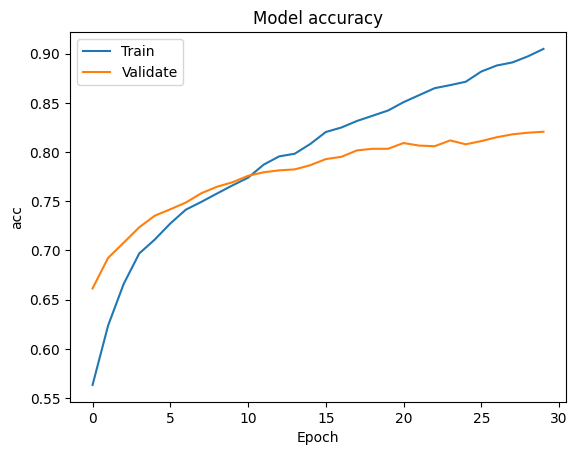

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

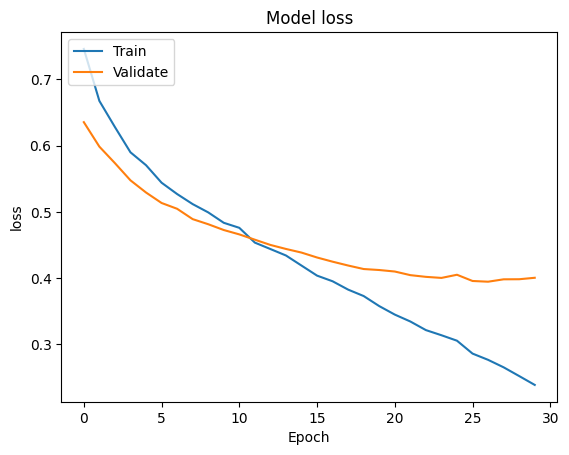

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(Data_test,Classes_test, verbose=1)
print("ResNet50 Score:",scores[1])

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8333 - loss: 0.3885
ResNet50 Score: 0.8324183225631714


W0000 00:00:1733902828.114123      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
predIdxs = model.predict(Data_test,batch_size=32)
predIdxs=np.argmax(predIdxs,axis=1)

 10/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

W0000 00:00:1733902833.893749      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step


W0000 00:00:1733902839.722041      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
testy_res = Classes_test.argmax(axis=1)
CR = classification_report(testy_res, predIdxs)
print(CR)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1875
           1       0.86      0.81      0.83      1950

    accuracy                           0.83      3825
   macro avg       0.83      0.83      0.83      3825
weighted avg       0.83      0.83      0.83      3825



In [ ]:
# Get predictions for the test set
predictions = model.predict(Data_test)

# Convert predictions to class labels (0 for male, 1 for female)
predicted_labels = np.argmax(predictions, axis=1)

# Compare predicted labels with true labels
correct_predictions = np.sum(predicted_labels == np.argmax(Classes_test, axis=1))
total_samples = len(Classes_test)

# Calculate accuracy
accuracy = correct_predictions / total_samples
print("Test Accuracy:", accuracy)

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Test Accuracy: 0.8324183006535948


In [ ]:
class_names=['MALE','FEMALE']

In [ ]:
import random
def plot_prediction(Data_test, Classes_test, n_images, class_names):
    """
    Test the model on random predictions and plot the results.

    Args:
        Data_test (numpy array): The test images data.
        Classes_test (numpy array): The true labels for the test images.
        n_images (int): Number of images to plot.
        class_names (list): List of class names.
    """
    # Get the total number of test images
    num_images = len(Data_test)

    # Randomly select indices for the images to plot
    random_indices = random.sample(range(num_images), n_images)

    # Make predictions on the selected test data
    predictions = np.argmax(model.predict(Data_test[random_indices]), axis=1)

    # Plot the randomly selected images along with their true labels and predictions
    plt.figure(figsize=(14, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 3, i+1)
        plt.imshow(Data_test[idx])
        if predictions[i] == np.argmax(Classes_test[idx]):
            title_color = 'g'  # green color for correct predictions
        else:
            title_color = 'r'  # red color for incorrect predictions
        plt.title(class_names[np.argmax(Classes_test[idx])], color=title_color)
        plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


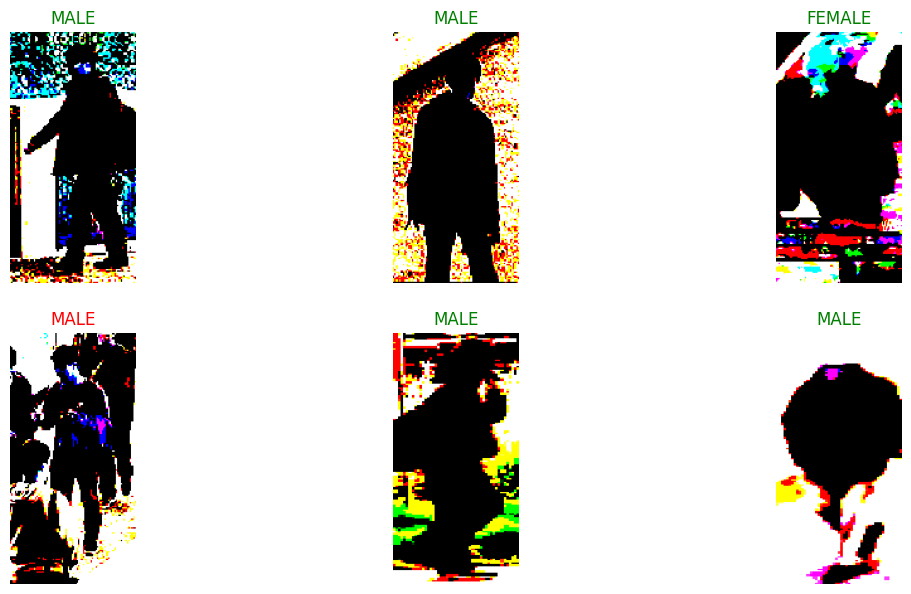

In [ ]:
plot_prediction(Data_test, Classes_test, n_images=6, class_names=class_names)

In [ ]:
model.save("GenderClassification.h5")

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input  # Replace with the appropriate preprocessing function if needed

# Define label mappings
int2labels = {0: "MALE", 1: "FEMALE"}

# Load the image of your girlfriend
image_path = "/kaggle/input/foto-carissa-sayang/WhatsApp Image 2024-12-11 at 14.29.32.jpeg"  # Replace with the actual path to the image
img = load_img(image_path, target_size=(200, 100))  # Resize to the same dimensions used during training

# Preprocess the image
img_array = img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Normalize the image

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Get the index of the highest probability

# Map the class index to the label
predicted_label = int2labels[predicted_class]

# Print the result
print(f"The model predicts that the person in the image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The model predicts that the person in the image is: FEMALE


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


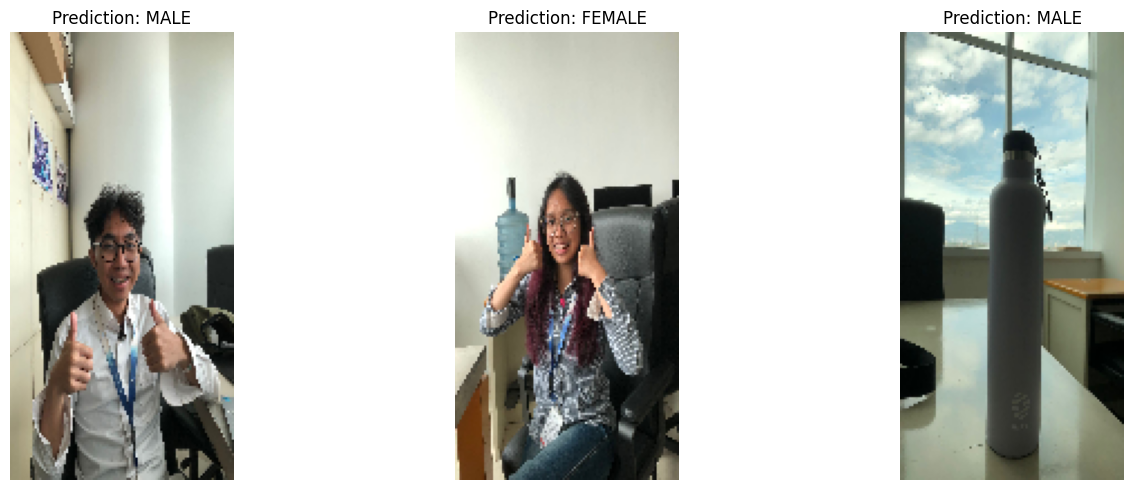

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input  # Replace with the appropriate preprocessing function if needed
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("GenderClassification.h5")

# Define label mappings
int2labels = {0: "MALE", 1: "FEMALE"}

# Paths to the images
image_paths = [
    "/kaggle/input/ael-and-botol-minum/WhatsApp Image 2024-12-11 at 14.50.33.jpeg",            # Path to your image
    "/kaggle/input/foto-carissa/WhatsApp Image 2024-12-11 at 14.29.32.jpeg",    # Path to your girlfriend's image
    "/kaggle/input/ael-and-botol-minum/WhatsApp Image 2024-12-11 at 14.50.35.jpeg"         # Path to a random image
]

# Create a figure for displaying images
plt.figure(figsize=(15, 5))

# Loop through each image, preprocess it, and predict
for i, image_path in enumerate(image_paths):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(200, 100))  # Resize to the same dimensions used during training
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize the image

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Get the index of the highest probability
    predicted_label = int2labels[predicted_class]  # Map the class index to the label

    # Display the image and prediction result
    plt.subplot(1, 3, i + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Prediction: {predicted_label}")

# Show all the images
plt.tight_layout()
plt.show()